<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'preferential_followers', 'preferential_followee',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_dot_u',
       'svd_dot_v'],
      dtype='object')

In [4]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [5]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [6]:
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

estimator1 = xgb.XGBRFClassifier(objective= 'binary:logistic',
eval_metric= 'auc',scale_pos_weight = 1,random_state=123)

Rsearch1= RandomizedSearchCV(estimator1,param_distributions=param_dist,scoring='f1',n_jobs=-1,iid=False, cv=10,verbose=20,random_state=123)

Rsearch1.fit(df_final_train,y_train)

Rsearch1.best_params_, Rsearch1.best_score_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 23

({'max_depth': 14,
  'min_samples_leaf': 32,
  'min_samples_split': 162,
  'n_estimators': 111},
 0.9749475494495659)

In [9]:
print('CV scores',Rsearch1.cv_results_)

CV scores {'mean_fit_time': array([ 361.04150612,  328.09393704,  294.88804049,  412.23543234,
       1085.78301475, 1682.80843396, 1060.22566819,  227.5500165 ,
        294.28732769,  284.4111546 ]), 'std_fit_time': array([   2.07277761,    5.83773985,    2.97909992,   12.5289976 ,
        567.96512413,  657.6843855 , 1033.13802748,   21.08867587,
          7.76833919,   28.29952222]), 'mean_score_time': array([0.32787554, 0.29756455, 0.2613236 , 0.38136878, 1.43576951,
       1.25932388, 0.21199448, 0.21598737, 0.27206993, 0.24295423]), 'std_score_time': array([0.03734219, 0.01574592, 0.02093322, 0.03062442, 0.71392273,
       0.92689331, 0.06719942, 0.03941758, 0.04094229, 0.05120621]), 'param_max_depth': masked_array(data=[12, 12, 10, 14, 13, 14, 11, 11, 12, 12],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[53, 47, 57, 57, 27

In [10]:
print('mean test scores',Rsearch1.cv_results_['mean_test_score'])


mean test scores [0.97421554 0.97425463 0.9726519  0.97484641 0.97466341 0.97494755
 0.97372577 0.97369785 0.97425513 0.97423583]


In [11]:
print(Rsearch1.best_estimator_)
print(Rsearch1.best_params_)
print(Rsearch1.best_score_)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=1,
                max_delta_step=0, max_depth=14, min_child_weight=1,
                min_samples_leaf=32, min_samples_split=162, missing=None,
                n_estimators=111, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=123, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)
{'max_depth': 14, 'min_samples_leaf': 32, 'min_samples_split': 162, 'n_estimators': 111}
0.9749475494495659


In [12]:


l=Rsearch1.best_params_["min_samples_leaf"]
d=Rsearch1.best_params_['max_depth']
s=Rsearch1.best_params_['min_samples_split']
n=Rsearch1.best_params_['n_estimators']



In [15]:
final_clf = xgb.XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
        colsample_bytree=0.7, eval_metric='auc', gamma=0.2,
        learning_rate=0.5, max_delta_step=0, max_depth=14,
        min_child_weight=1, min_samples_leaf=32, min_samples_split=162,
        missing=None, n_estimators=111, n_jobs=-1, nthread=None,
        objective='binary:logistic', scale_pos_weight=1, seed=None,
        silent=None, subsample=0.9, verbosity=1)

final_clf.fit(df_final_train,y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.7, eval_metric='auc', gamma=0.2,
                learning_rate=0.5, max_delta_step=0, max_depth=14,
                min_child_weight=1, min_samples_leaf=32, min_samples_split=162,
                missing=None, n_estimators=111, n_jobs=-1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.9, verbosity=1)

In [16]:
predict_y_test_final = final_clf.predict(df_final_test)
predict_y_train_final = final_clf.predict(df_final_train)

print("The train f1 score is:",f1_score(y_train,predict_y_train_final))
print("The test f1 score is:",f1_score(y_test,predict_y_test_final))

The train f1 score is: 0.9836847667455084
The test f1 score is: 0.9322415644010357


In [17]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


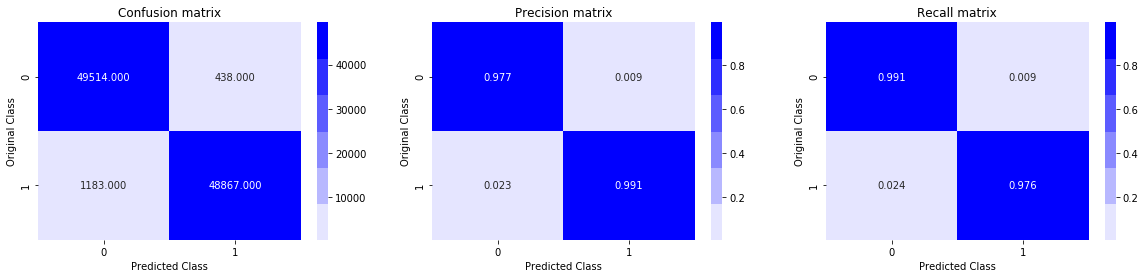

Test confusion_matrix


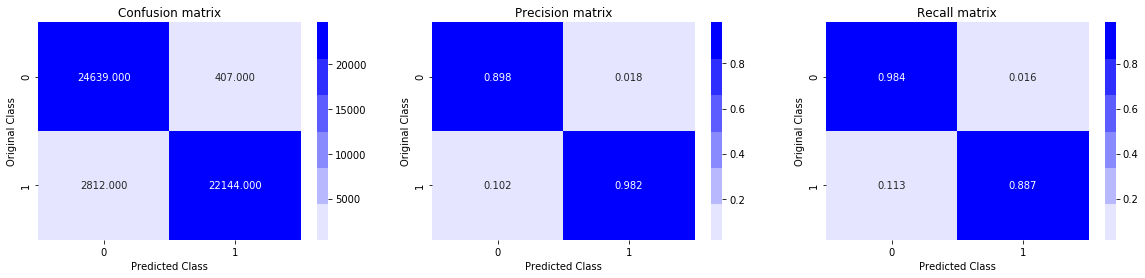

In [19]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,predict_y_train_final)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,predict_y_test_final)

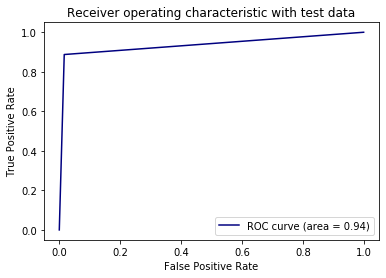

In [20]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,predict_y_test_final)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

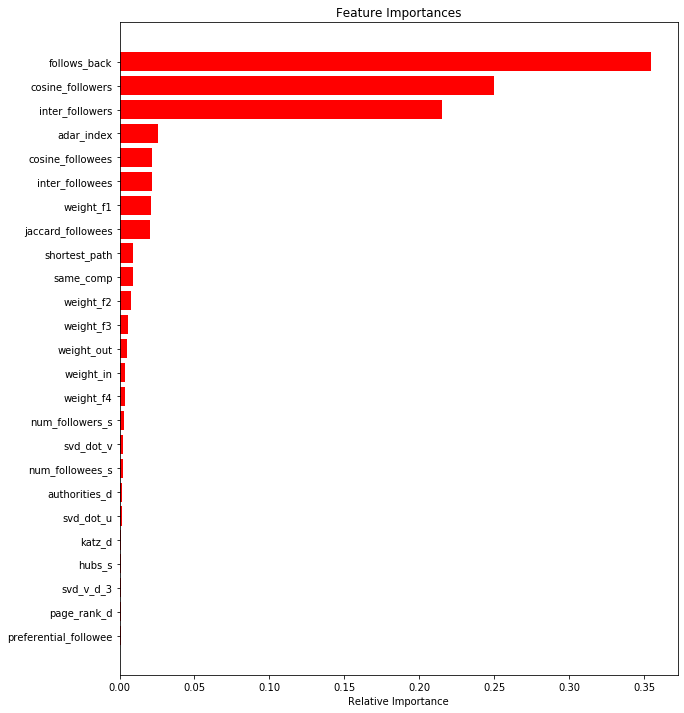

In [22]:
features = df_final_train.columns
importances = final_clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()